In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the MiDaS depth estimation model from TensorFlow Hub

In [10]:
model_url = "https://tfhub.dev/intel/midas/v2_1_small/1"
depth_model = hub.load(model_url, tags=["serve"])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# Preprocess image: resize, normalize, batch

In [11]:
def load_and_preprocess(image_url):
    image_path = tf.keras.utils.get_file("input.jpg", origin=image_url)
    img = Image.open(image_path).convert("RGB").resize((256, 256))       # Resize image
    img = np.array(img).astype(np.float32) / 255.0                       # Normalize
    img = tf.convert_to_tensor(img)
    img = tf.image.resize(img, (256, 256))
    return tf.expand_dims(img, 0)                                        # Add batch dimension

# Load sample image

In [12]:
image_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg"
input_image = load_and_preprocess(image_url)

# Run inference to get depth map

In [15]:
# Transpose input to channels-first if needed
input_image_chw = tf.transpose(input_image, [0, 3, 1, 2])

# Try running the model with transposed input
try:
	depth_map = depth_model.signatures['serving_default'](input_image_chw)['default'][0]  # Remove batch dimension
except Exception as e:
	# If it fails, fall back to channels-last
	depth_map = depth_model.signatures['serving_default'](input_image)['default'][0]

depth_map = tf.image.resize(depth_map[..., tf.newaxis], (256, 256))               # Resize for visualization

# Normalize depth for display

In [16]:
depth_min = tf.reduce_min(depth_map)
depth_max = tf.reduce_max(depth_map)
normalized_depth = (depth_map - depth_min) / (depth_max - depth_min)

# Show original image and predicted depth

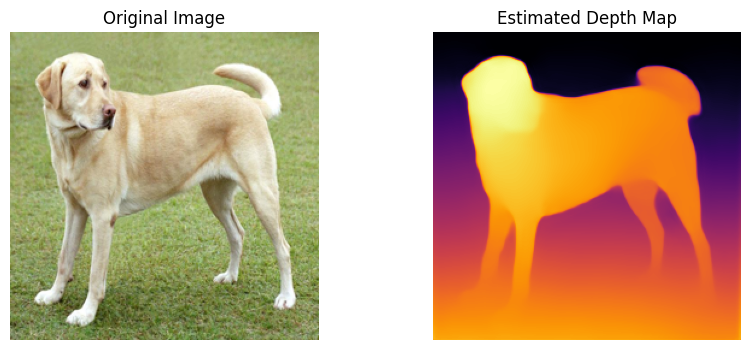

In [17]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(tf.squeeze(input_image))
plt.title("Original Image")
plt.axis('off')
 
plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(normalized_depth), cmap='inferno')
plt.title("Estimated Depth Map")
plt.axis('off')
plt.show()